In [1]:
%load_ext autoreload
%autoreload 2

### Imports

Internal imports

In [2]:
# Find ".env" file and add the package to $PATH
import os, sys
import typing as t
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv()))
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "platform"

# Use local package for modularity
import emotion_analysis as ea
import emotion_analysis.data.dataset as data
from emotion_analysis.data.transform import Tokenize
from emotion_analysis.model.emotion_cause_text import load_text_model

JAX Backend:  gpu
JAX Version:  0.4.23
Python:  3.11.0 (main, Oct  4 2023, 22:00:02) [GCC 13.2.1 20230801]
System:  posix.uname_result(sysname='Linux', nodename='archlinux', release='6.6.8-arch1-1', version='#1 SMP PREEMPT_DYNAMIC Thu, 21 Dec 2023 19:01:01 +0000', machine='x86_64')


External Imports

In [3]:
import mlflow
import re
import jax
import jax.numpy as jnp
import jax.random as rng
import optax as opt
import numpy as np
import pandas as pd
import dataclasses
import seaborn as sea
import wordcloud as wc
import matplotlib as mpl
import matplotlib.pyplot as plt
from transformers import RobertaTokenizerFast, BatchEncoding

### Utils

Setup presentation

In [4]:
sea.set_theme('notebook', style='whitegrid')

Utilities

In [82]:
# Load dataset
dataset = data.ECACDataset(ea.DATA_DIR, 'task_1', 'train')
data_copy = dataset.data_.copy(True)

# Load tokenizer
tokenizer = load_text_model()[2]
tokenize = Tokenize(tokenizer, max_length=None, padding='longest')

# Tokenize all convesations
data_copy['input_ids'] = data_copy['text'].apply(lambda x: tokenize(x).data['input_ids'][0])

### Perform mapping between `cause_start` and `cause_stop` in `input_ids` space

#### Using `DataFrame`

In [55]:
sample_data, sample_label = dataset[0]
sample_data

,conversation_id,utterance_id,speaker,text,emotion,video_path
0,0,0,Chandler,"Alright , so I am back in high school , I am s...",0,None
1,0,1,All,"Oh , yeah . Had that dream .",0,None
2,0,2,Chandler,"Then I look down , and I realize there is a ph...",2,None
3,0,3,Joey,Instead of ... ?,2,None
4,0,4,Chandler,That is right .,1,None
5,0,5,Joey,Never had that dream .,0,None
6,0,6,Phoebe,No .,0,None
7,0,7,Chandler,"All of a sudden , the phone starts to ring .",0,None


In [56]:
sample_label = t.cast(pd.DataFrame, sample_label)
sample_label

,conversation_id,utterance_id,emotion,cause_id,cause_start,cause_stop
0,0,2,2,0,91,120
1,0,2,2,2,0,60
2,0,3,2,0,91,120
3,0,3,2,2,0,60
4,0,3,2,3,0,13
5,0,4,1,0,91,120
6,0,4,1,2,0,60
7,0,4,1,3,0,13


In [57]:
ec_pair = sample_label.iloc[0]
ec_pair

conversation_id      0
utterance_id         2
emotion              2
cause_id             0
cause_start         91
cause_stop         120
Name: 0, dtype: int64

In [58]:
emotion = sample_data.iloc[ec_pair['utterance_id']]
emotion

conversation_id                                                    0
utterance_id                                                       2
speaker                                                     Chandler
text               Then I look down , and I realize there is a ph...
emotion                                                            2
video_path                                                      None
Name: 2, dtype: object

In [59]:
cause = sample_data.iloc[ec_pair['cause_id']]
cause

conversation_id                                                    0
utterance_id                                                       0
speaker                                                     Chandler
text               Alright , so I am back in high school , I am s...
emotion                                                            0
video_path                                                      None
Name: 0, dtype: object

In [60]:
span = cause['text'][ec_pair['cause_start']: ec_pair['cause_stop']]
span

'I realize I am totally naked '

#### Using `HF`

In [61]:
emotion_encoding = tokenize(emotion['text'])
emotion_encoding.tokens()

['<s>',
 'Then',
 'ĠI',
 'Ġlook',
 'Ġdown',
 'Ġ,',
 'Ġand',
 'ĠI',
 'Ġrealize',
 'Ġthere',
 'Ġis',
 'Ġa',
 'Ġphone',
 'Ġ...',
 'Ġthere',
 'Ġ.',
 '</s>']

In [62]:
emotion_encoding.char_to_token(0)

1

In [63]:
emotion_encoding.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, None]

In [64]:
def char_span_to_tokens(start: int, stop: int, text: str):
    encoding = tokenizer(text)
    tokens = encoding.tokens()

    for i in range(start, stop):
        # Retrieve token_id per char_index
        token_id = encoding.char_to_token(i)
        token = tokens[token_id] if token_id else None
        
        # Traverse and showcase the process 
        print('char_index={}, char={}, token_id={}, token={}' \
                .format(i, text[i], token_id, token))

    return encoding.char_to_token(start), encoding.char_to_token(stop - 1)

In [65]:
char_span_to_tokens(
    ec_pair['cause_start'],
    ec_pair['cause_stop'],
    cause['text'],
)

char_index=91, char=I, token_id=22, token=ĠI
char_index=92, char= , token_id=None, token=None
char_index=93, char=r, token_id=23, token=Ġrealize
char_index=94, char=e, token_id=23, token=Ġrealize
char_index=95, char=a, token_id=23, token=Ġrealize
char_index=96, char=l, token_id=23, token=Ġrealize
char_index=97, char=i, token_id=23, token=Ġrealize
char_index=98, char=z, token_id=23, token=Ġrealize
char_index=99, char=e, token_id=23, token=Ġrealize
char_index=100, char= , token_id=None, token=None
char_index=101, char=I, token_id=24, token=ĠI
char_index=102, char= , token_id=None, token=None
char_index=103, char=a, token_id=25, token=Ġam
char_index=104, char=m, token_id=25, token=Ġam
char_index=105, char= , token_id=None, token=None
char_index=106, char=t, token_id=26, token=Ġtotally
char_index=107, char=o, token_id=26, token=Ġtotally
char_index=108, char=t, token_id=26, token=Ġtotally
char_index=109, char=a, token_id=26, token=Ġtotally
char_index=110, char=l, token_id=26, token=Ġtotally

(22, None)

### Data Analysis

#### Determine the `max_length` of a conversation

In [83]:
max_length = data_copy['conversation_id'].value_counts(sort=False).max()
print('Max Conversation Length: {}'.format(max_length))

Max Conversation Length: 33


#### Determine what should be `max_length` and what is the `avg_length` w.r.t. `input_ids`:

In [66]:
min_length = min(data_copy['input_ids'].apply(lambda x: len(x)))
print('Min Utterance Length: {}'.format(min_length))

max_length = max(data_copy['input_ids'].apply(lambda x: len(x)))
print('Max Utterance Length: {}'.format(max_length))

avg_length = sum(data_copy['input_ids'].apply(lambda x: len(x))) / len(data_copy)
print('Avg Utterance Length: {:.2f}'.format(avg_length))

Min Utterance Length: 3
Max Utterance Length: 93
Avg Utterance Length: 13.62


#### Analyze how many `utterances` are per-emotion

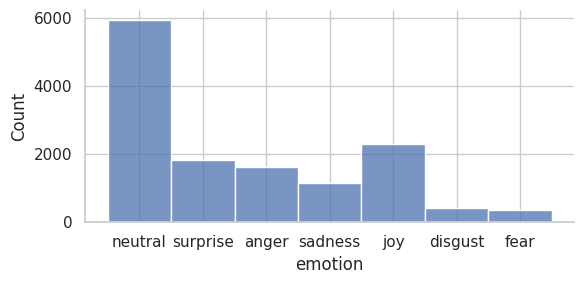

In [67]:
data_copy['emotion'] = data_copy['emotion'].map(dataset.class_to_emotion)
sea.displot(data=data_copy, x='emotion', bins=7, kind='hist', aspect=2, height=3)

#### Analyze the most `frequent words` per-emotion

In [68]:
emotion_text = data_copy.groupby('emotion')[['text']].agg(lambda x: ' '.join(x))
emotion_text

,text
emotion,
anger,"That is right . Yeah , well , you did not know..."
disgust,"I mean , why should I let them meet him ? I me..."
fear,Nuh ... uh . Janice . Ok . Uh ... oh . Uh ... ...
joy,"That is one way ! Oh , look , wish me luck ! I..."
neutral,"Alright , so I am back in high school , I am s..."
sadness,"I do not want to be single , okay ? I just ......"
surprise,"Then I look down , and I realize there is a ph..."


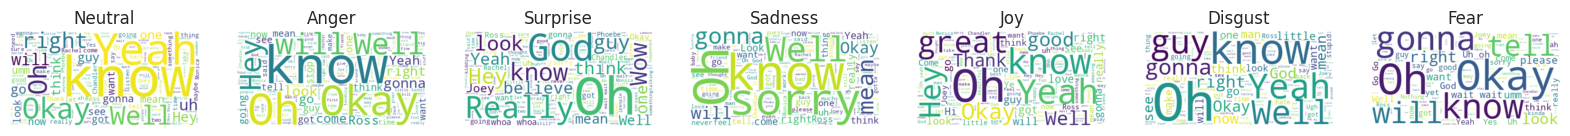

In [69]:
fig, axis = plt.subplots(1, 7, figsize=(20, 20))
word_cloud = wc.WordCloud(background_color='white')

for i, ax in enumerate(axis):
    emotion = dataset.class_to_emotion[i]
    image = word_cloud.generate(emotion_text.loc[emotion]['text']).to_image()
    ax.set_title(emotion.capitalize())
    ax.set_axis_off()
    ax.grid(False)
    ax.imshow(image, interpolation='bilinear')

plt.show()